In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
sns.set()
sns.set_style(style="whitegrid")
sns.set_color_codes("colorblind")

# Simulation

In [3]:
N_DAYS = 60
N_SIM = 1000

N_PEOPLE = 1000
S0 = 999
I0 = 1

HEALTH_COST = 1

In [4]:
# This function implements Eq. 2
def simulate_new_day(S, I, p, N, approx):
    Inew = np.random.binomial(S, 1 - (1-p)**I, N)  # generates N results from the given binomial
    Inew = approx(Inew.mean())  # gets the mean of the N simulations

    Snew = S - Inew

    return Inew, Snew

In [5]:
data = []
cost = []

np.random.seed(42)  # setting the seed we can repeat the experiment obtaining the same results each time

for p in np.linspace(0.0005, 0.003, 11):
    data.append([0, I0, "infected", p])
    data.append([0, S0, "susceptible", p])
    data.append([0, N_PEOPLE - I0 - S0, "removed", p])  # number of removed, implements Eq. 1

    Iold = I0
    Sold = S0

    c_economy = (0.003 / p)**9 - 1  # cost on the economy, implements Eq. 3
    c_health = I0 * HEALTH_COST  # cost on health system for the first day

    for day in range(N_DAYS-1):
        Inew, Snew = simulate_new_day(Sold, Iold, p, N_SIM, lambda x: round(x))

        c_health += Inew * HEALTH_COST  # health cost of the day

        data.append([day+1, Inew, "infected", p])
        data.append([day+1, Snew, "susceptible", p])
        data.append([day+1, N_PEOPLE - Inew - Snew, "removed", p])

        Iold = Inew
        Sold = Snew

    cost.append([(c_economy + c_health) / N_DAYS, p])  # add the average overall cost over the 60 days
            # implements Eq. 4

data = pd.DataFrame(data, columns=["Day", "n", "Class", "p"])
cost = pd.DataFrame(cost, columns=["Cost per day", "p"])

In [6]:
data.head(6)

,Day,n,Class,p
0,0,1,infected,0.0005
1,0,999,susceptible,0.0005
2,0,0,removed,0.0005
3,1,0,infected,0.0005
4,1,999,susceptible,0.0005
5,1,1,removed,0.0005


### Visual representations

In [ ]:
# Fig. 1
fig, ax = plt.subplots(3, 1, figsize=(7, 18))
ax[0].set_title("p=0.003")
sns.lineplot(data=data[data["p"]==0.003], x="Day", y="n", hue="Class", ax=ax[0])
ax[1].set_title("p=0.0015")
sns.lineplot(data=data[data["p"]==0.0015], x="Day", y="n", hue="Class", ax=ax[1])
ax[2].set_title("p=0.0005")
sns.lineplot(data=data[data["p"]==0.0005], x="Day", y="n", hue="Class", ax=ax[2])

plt.plot()
plt.savefig("./img/infection_trend.pdf", bbox_inches='tight')

In [ ]:
# Fig. 2
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.scatterplot(data=cost, x="p", y="Cost per day", ax=ax[0])
sns.scatterplot(data=cost[cost["p"]>=0.0015], x="p", y="Cost per day", ax=ax[1])

plt.plot()
plt.savefig("./img/cost_by_p.pdf", bbox_inches="tight")

# Neural network function fitting

In [9]:
cost_of_interest = cost[cost["p"]>=0.00125].copy(deep=True)

cost_of_interest.index = [i for i in range(len(cost_of_interest))]

In [10]:
class NN:
    def __init__(self, **kwargs):
        self.hidden_nodes = kwargs["hn"]
        self.bias_in_bound = kwargs["bib"]
        self.bias_hidden_bound = kwargs["bhb"]
        self.w_bound = kwargs["wb"]
        self.k_bound = kwargs["kb"]
        self.tol = kwargs["tol"]
        self.learning_rate = kwargs["lr"]
        self.max_epochs = kwargs["me"]
        
        self.Xscaler, self.yscaler = MinMaxScaler(kwargs["sri"]), MinMaxScaler(kwargs["sro"])

        self.W, self.What, self.K, self.Khat = None, None, None, None
        self.Bi, self.Bh = None, None
        
        self.loss = []

    def fit(self, X, y):
        X = self.Xscaler.fit_transform(X)
        Xhat = np.hstack((X, np.ones((X.shape[0], 1))))
        y = self.yscaler.fit_transform(y)
        
        self.Bi = np.random.uniform(0, self.bias_in_bound, size=(1, self.hidden_nodes))
        self.Bh = np.random.uniform(0, self.bias_hidden_bound, size=(1, y.shape[1]))

        self.W = np.random.uniform(0, self.w_bound, size=(Xhat.shape[1]-1, self.hidden_nodes))
        self.What = np.vstack((self.W, self.Bi))  # implements Eq. 8
        self.K = np.random.uniform(0, self.k_bound, size=(self.hidden_nodes, y.shape[1]))
        self.Khat = np.vstack((self.K, self.Bh))  # implements Eq. 11

        SSEold = 100
        epoch = 0
        flag = True

        while flag and epoch < self.max_epochs:
            epoch += 1

            Vstar = Xhat @ self.What  # implements Eq. 9
            V = self.__activate(Vstar)
            Vhat = np.hstack((V, np.ones((V.shape[0], 1))))  # implements Eq. 10

            O = Vhat @ self.Khat  # implements Eq. 12

            e = y - O

            dW = Xhat.T @ (((e * 1) @ self.Khat.T) * self.__deactivate(Vhat))  # implements Eq. 13
            dWstar = dW[:, :-1]
            self.What += 2 * self.learning_rate(epoch) * dWstar  # implements Eq. 14

            dK = Vhat.T @ (e * 1)  # implements Eq. 15
            self.Khat += 2 * self.learning_rate(epoch) * dK  # implements Eq. 16

            SSEnew = np.sum(e**2)
            self.loss.append(SSEnew)
            if np.abs(SSEnew - SSEold) < self.tol:
                flag = False
            else:
                SSEold = SSEnew
        
    def predict(self, X):
        X = self.Xscaler.transform(X)
        Xhat = np.hstack((X, np.ones((X.shape[0], 1))))

        Vstar = Xhat @ self.What
        V = self.__activate(Vstar)
        Vhat = np.hstack((V, np.ones((V.shape[0], 1))))

        O = Vhat @ self.Khat

        return self.yscaler.inverse_transform(O)

    @staticmethod
    def __activate(u):
        return 1 / (1 + np.exp(-4 * u))  # implements Eq. 5

    @staticmethod
    def __deactivate(u):
        return 4 * u * (1 - u)  # derivative of Eq. 5

In [11]:
# TABLE I
params = {
    "hn": 5,
    "bib": .5,
    "bhb": .5,
    "wb": .3,
    "kb": .3,
    "tol": 1e-8,
    "lr": lambda t: 1e-4*np.sqrt(t),  # implements Eq. 6
    "me": 1000000,
    "sri": (-2, 2),
    "sro": (0, 1)
}

In [12]:
nn = NN(**params)
np.random.seed(42)
nn.fit(np.array(cost_of_interest["p"]).reshape(-1, 1), np.array(cost_of_interest["Cost per day"]).reshape(-1, 1))

y_hat = nn.predict(np.linspace(0.00125, 0.003, 10001).reshape(-1, 1))

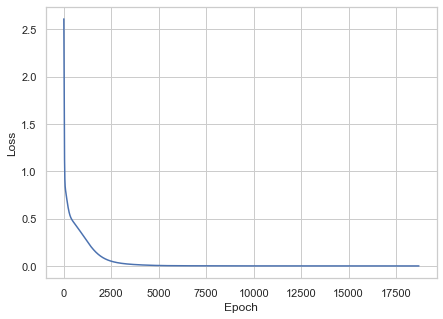

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(nn.loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.plot()
plt.savefig("./img/loss.pdf", bbox_inches="tight")

In [14]:
pred = np.hstack((y_hat, np.linspace(0.00125, 0.003, 10001).reshape(-1, 1)))
costs = pd.DataFrame(pred, columns=["Cost per day", "p"])
costs["Class"] = "predicted"

In [15]:
sim = []

for p in np.linspace(0.00125, 0.003, 10001):

    Iold = I0
    Sold = S0

    c_economy = (0.003 / p)**9 - 1  # containment cost, implements Eq. 3
    c_health = Iold * HEALTH_COST  # cost for health on the first day

    for day in range(N_DAYS-1):
        Inew, Snew = simulate_new_day(Sold, Iold, p, 10000, lambda x: x)

        c_health += Inew * HEALTH_COST  # health cost of the day

        Iold = Inew
        Sold = Snew

    sim.append([(c_economy + c_health) / N_DAYS, p])

simulation = pd.DataFrame(sim, columns=["Cost per day", "p"])
simulation["Class"] = "simulated"

costs = costs.append(simulation, ignore_index=True)

In [ ]:
# Fig. 4
fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=costs[costs["Class"]=="predicted"], x="p", y="Cost per day", ax=ax)
sns.scatterplot(data=cost_of_interest, x="p", y="Cost per day", ax=ax)
ax.set_xlabel("p")
ax.set_ylabel("Cost per day")

plt.plot()
plt.savefig("./img/nn_output.pdf", bbox_inches="tight")

In [ ]:
# Fig. 6
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.lineplot(data=costs, x="p", y="Cost per day", hue="Class", ax=ax[0])
sns.lineplot(data=costs, x="p", y="Cost per day", hue="Class", ax=ax[1])
ax[1].scatter(np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="predicted", "Cost per day"])], np.min(costs.loc[costs["Class"]=="predicted", "Cost per day"]))
ax[1].scatter(np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="simulated", "Cost per day"])], np.min(costs.loc[costs["Class"]=="simulated", "Cost per day"]))
ax[1].set_xlim(0.00175, 0.00195)
ax[1].set_ylim(13.5, 14.25)

plt.plot()
plt.savefig("./img/pred_vs_sim.pdf", bbox_inches="tight")

In [18]:
mean_squared_error(costs.loc[costs["Class"]=="simulated", "Cost per day"], costs.loc[costs["Class"]=="predicted", "Cost per day"])

0.41806568059576626

In [19]:
mean_absolute_error(costs.loc[costs["Class"]=="simulated", "Cost per day"], costs.loc[costs["Class"]=="predicted", "Cost per day"])

0.25455970598382643

# Minima

In [20]:
(np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="predicted", "Cost per day"])], np.min(costs.loc[costs["Class"]=="predicted", "Cost per day"]))

(0.001849725, 13.698125361362978)

In [21]:
np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="simulated", "Cost per day"])], np.min(costs.loc[costs["Class"]=="simulated", "Cost per day"])

(0.001871425, 13.774568732649845)

### Using the slope

In [22]:
c = costs.loc[costs["Class"]=="predicted", "Cost per day"].to_numpy()
dy = np.zeros(len(c)-1)
for i in range(len(c)-1):
    dy[i] = c[i+1] - c[i]
    
dx = (0.003 - 0.00125) / 10001

In [23]:
dc = dy / dx

dc = np.append(dc, dc[-1])

In [ ]:
# Fig. 5
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].plot(np.linspace(0.00125, 0.003, 10001), dc)
ax[0].set_ylabel("slope Cost per day")
ax[0].set_xlabel("p")
ax[1].scatter(np.linspace(0.00125, 0.003, 10001), dc)
ax[1].plot(np.linspace(0.00125, 0.003, 10001), dc)
ax[1].set_ylabel("slope Cost per day")
ax[1].set_xlabel("p")
ax[1].set_xlim(0.0018490, 0.0018500)
ax[1].set_ylim(-10, 10)

plt.plot()
plt.savefig("./img/derivative.pdf", bbox_inches="tight")

In [25]:
xi, xj = np.linspace(0.00125, 0.003, 10001)[np.argmin(np.abs(dc))], np.linspace(0.00125, 0.003, 10001)[np.argmin(np.abs(dc))+1]
yi, yj = dc[np.argmin(np.abs(dc))], dc[np.argmin(np.abs(dc))+1]

print(xi, xj)

m = (yj-yi)/(xj-xi)
q = yi - m*xi
print(-q/m)

0.0018495500000000002 0.001849725
0.0018496261455238075


In [26]:
nn.predict(np.array([[-q/m]]))

array([[13.69812546]])